In [21]:
import re
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

# Configuración global
STOPWORDS = set(stopwords.words("english"))
LEMMATIZER = WordNetLemmatizer()
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 100


In [22]:
# --- Procesamiento de texto básico --- 
def clean_text(text: str) -> str:
    """Limpia texto eliminando URLs, menciones, símbolos y espacios."""
    text = re.sub(r"http\S+|@\w+|[^a-zA-Z\s]", "", text)
    return text.lower().strip()

def correct_spelling(text: str) -> str:
    """Corrige ortografía de un texto usando TextBlob."""
    return str(TextBlob(text).correct())

def tokenize(text: str) -> List[str]:
    """Tokeniza y elimina stopwords."""
    return [word for word in text.split() if word not in STOPWORDS]


# --- Frecuencias --- #
def get_word_counts(texts: List[str], token_pattern: str = r"\b[a-zA-Z]+\b") -> Dict[str, int]:
    """Calcula frecuencias con CountVectorizer."""
    vectorizer = CountVectorizer(lowercase=True, token_pattern=token_pattern)
    word_matrix = vectorizer.fit_transform(texts)
    freqs = word_matrix.sum(axis=0).A1
    return dict(zip(vectorizer.get_feature_names_out(), freqs))

def sort_frequencies(freqs: Dict[str, int], top_n: int = 20) -> List[Tuple[str, int]]:
    """Ordena frecuencias de mayor a menor."""
    return sorted(freqs.items(), key=lambda x: x[1], reverse=True)[:top_n]

def get_vocabulary_stats(texts: List[str]) -> Tuple[int, int]:
    vectorizer = CountVectorizer(lowercase=True, token_pattern=r'\b[a-zA-Z]+\b')
    matrix = vectorizer.fit_transform(texts)
    vocab_size = len(vectorizer.get_feature_names_out())
    total_words = matrix.sum()
    return vocab_size, total_words


# --- Visualizaciones --- #
def plot_target_distribution(target_counts: pd.Series):
    plt.pie(target_counts.values, labels=target_counts.index.map({0: "Non-disaster", 1: "Disaster"}), 
            autopct="%1.1f%%", startangle=90)
    plt.title("Target Distribution")

def plot_text_length_distribution(texts: pd.Series):
    lengths = texts.str.len()
    plt.hist(lengths, bins=50, color="skyblue", alpha=0.7)
    plt.title("Text Length Distribution")
    plt.xlabel("Characters")
    plt.ylabel("Frequency")

def plot_word_count_distribution(texts: pd.Series):
    counts = texts.str.split().str.len()
    plt.hist(counts, bins=30, color="lightcoral", alpha=0.7)
    plt.title("Word Count Distribution")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")

def plot_top_keywords(keywords: pd.Series, top_n: int = 10):
    top_keywords = keywords.value_counts().head(top_n)
    plt.barh(range(len(top_keywords)), top_keywords.values)
    plt.yticks(range(len(top_keywords)), top_keywords.index)
    plt.title("Top Keywords")
    plt.xlabel("Frequency")
    
def plot_all_summary_stats(df: pd.DataFrame):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    plt.sca(axes[0, 0])
    plot_target_distribution(df["target"].value_counts())

    plt.sca(axes[0, 1])
    plot_text_length_distribution(df["text"])

    plt.sca(axes[1, 0])
    plot_word_count_distribution(df["text"])

    plt.sca(axes[1, 1])
    plot_top_keywords(df["keyword"])

    plt.tight_layout()
    plt.show()

def plot_bar_chart(x_values, y_values, title, xlabel, ylabel, rotation=0):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=x_values, y=y_values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

def plot_zipf_law(freqs: Dict[str, int], top_n: int = 100):
    """Visualiza ley de Zipf y su ajuste teórico."""
    sorted_freqs = sorted(freqs.values(), reverse=True)[:top_n]
    ranks = np.arange(1, top_n + 1)
    zipf_theoretical = sorted_freqs[0] / ranks

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(ranks, sorted_freqs, 'bo-', alpha=0.7)
    ax1.set_title('Frecuencia por Rango')
    ax1.set_xlabel('Rango')
    ax1.set_ylabel('Frecuencia')

    ax2.loglog(ranks, sorted_freqs, 'ro-', label='Observado')
    ax2.loglog(ranks, zipf_theoretical, 'g--', label='Zipf Teórica')
    ax2.set_title('Ley de Zipf (escala log-log)')
    ax2.set_xlabel('Rango (log)')
    ax2.set_ylabel('Frecuencia (log)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return sorted_freqs[:4] 


In [23]:
# Cargar los datasets de entrenamiento y prueba
train_path = "/Users/pamelabenavides/repos/FCD_UV_2025/twitter_disaster_nlp/data/train.csv"
test_path = "/Users/pamelabenavides/repos/FCD_UV_2025/twitter_disaster_nlp/data/test.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

df_train.head()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [24]:
def print_dataset_summary(df: pd.DataFrame, target_col: str = "target") -> None:
    print("Resumen del dataset")
    print(f"Forma del dataset        : {df.shape}")
    print(f"Distribución de '{target_col}' : {df[target_col].value_counts().to_dict()}")
    missing = df.isnull().sum()
    missing = missing[missing > 0].to_dict()
    print(f"Valores faltantes        : {missing if missing else 'Ninguno'}")

print_dataset_summary(df_train)


Resumen del dataset
Forma del dataset        : (7613, 5)
Distribución de 'target' : {0: 4342, 1: 3271}
Valores faltantes        : {'keyword': 61, 'location': 2533}


In [25]:
# Análisis de tweets
all_texts = df_train['text'].tolist()
disaster_tweets = df_train[df_train['target'] == 1]['text']
non_disaster_tweets = df_train[df_train['target'] == 0]['text']

print("\nDisaster tweet samples:")
for i, tweet in enumerate(disaster_tweets.head(3), 1):
    print(f"{i}. {tweet[:100]}...")

print("\nNon-disaster tweet samples:")
for i, tweet in enumerate(non_disaster_tweets.head(3), 1):
    print(f"{i}. {tweet[:100]}...")


Disaster tweet samples:
1. Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all...
2. Forest fire near La Ronge Sask. Canada...
3. All residents asked to 'shelter in place' are being notified by officers. No other evacuation or she...

Non-disaster tweet samples:
1. What's up man?...
2. I love fruits...
3. Summer is lovely...


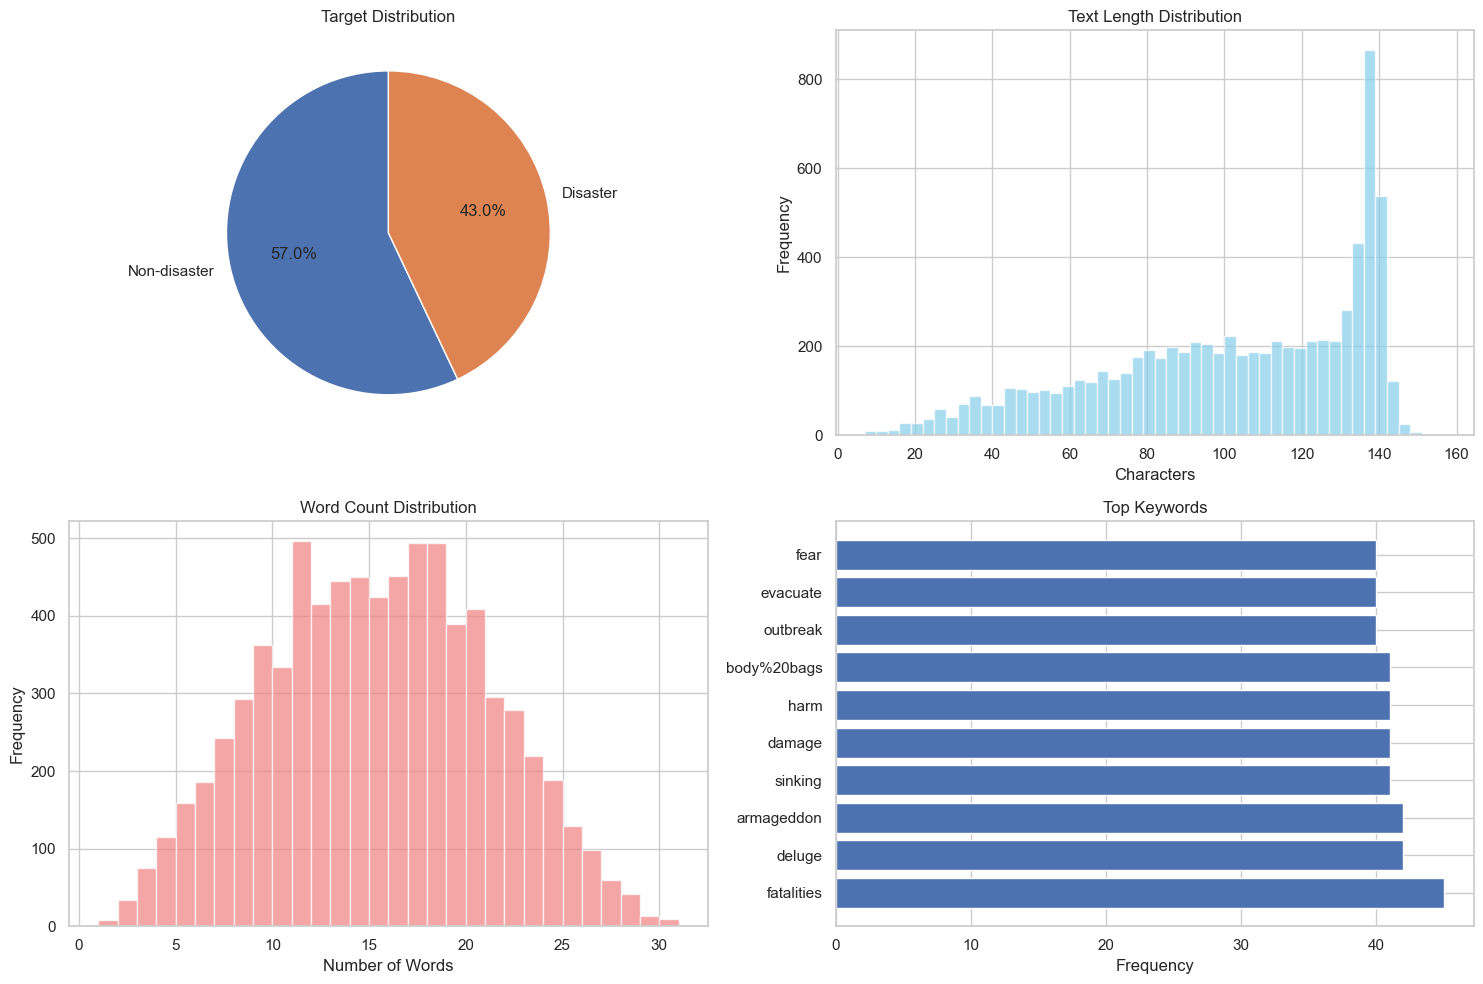

In [26]:
# Visualización de estadísticas descriptivas
plot_all_summary_stats(df_train)

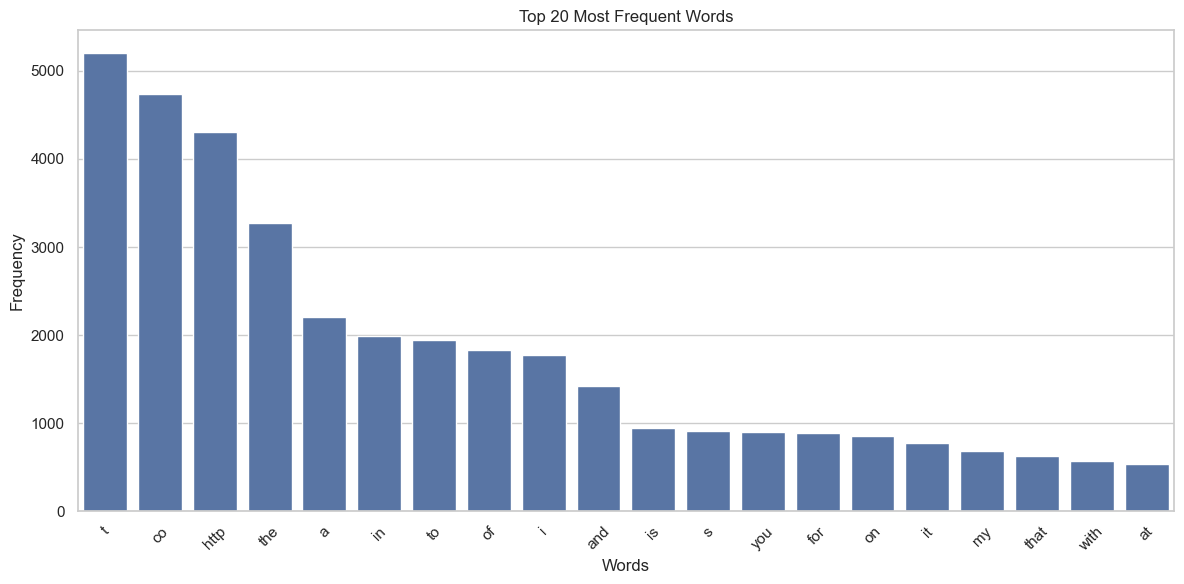

In [27]:
# Cálculo de frecuencias de palabras
word_freq_dict = get_word_counts(all_texts)

# Obtener las 20 palabras más frecuentes
top_words = sort_frequencies(word_freq_dict, top_n=20)
words, frequencies = zip(*top_words)

# Visualización
plot_bar_chart(
    x_values=words,
    y_values=frequencies,
    title="Top 20 Most Frequent Words",
    xlabel="Words",
    ylabel="Frequency",
    rotation=45
)

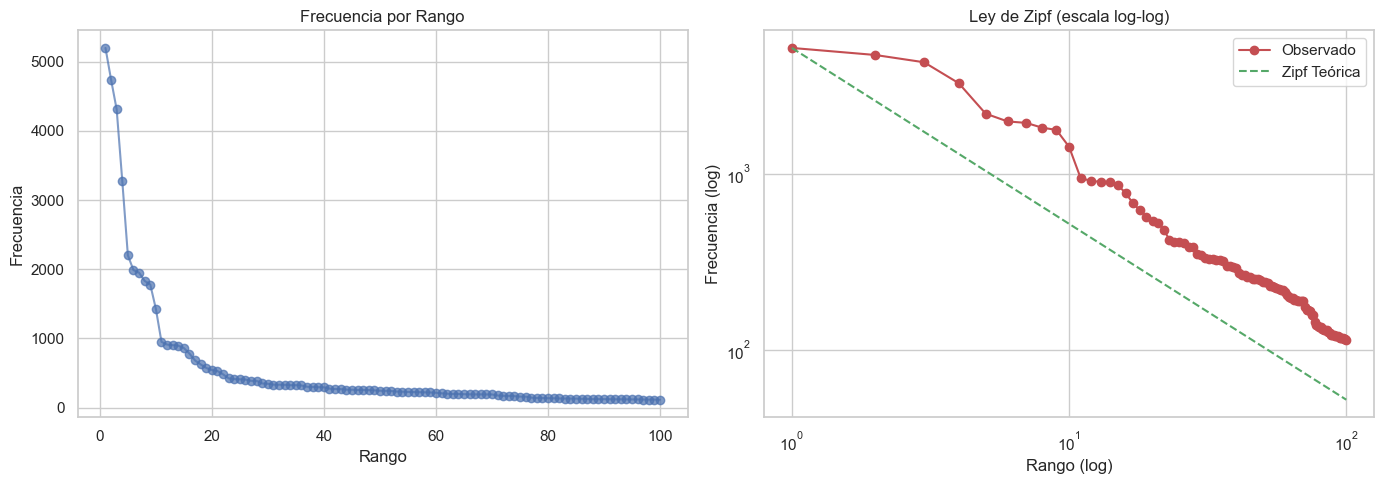

Zipf Law Analysis
Frecuencia palabra más común  : 5199
Ratio 1ª/2ª palabra (esperado ≈ 2.0): 1.10
Ratio 2ª/4ª palabra (esperado ≈ 2.0): 1.45


In [28]:
# Visualización de la ley de Zipf (y recuperación de primeras frecuencias)
top_freqs = plot_zipf_law(word_freq_dict, top_n=100)

# Análisis de proporciones entre palabras
first, second, fourth = top_freqs[0], top_freqs[1], top_freqs[3]
ratio_1_2 = first / second
ratio_2_4 = second / fourth

# Resultado profesional sin adornos
print("Zipf Law Analysis")
print(f"Frecuencia palabra más común  : {first}")
print(f"Ratio 1ª/2ª palabra (esperado ≈ 2.0): {ratio_1_2:.2f}")
print(f"Ratio 2ª/4ª palabra (esperado ≈ 2.0): {ratio_2_4:.2f}")


## Conteo de Palabras y Ley de Zipf

Se utilizó CountVectorizer para contar la frecuencia de las palabras presentes en los tweets. Luego, se graficaron las 20 más frecuentes, lo que permitió observar patrones claros en el uso del lenguaje.

Además, se analizó la **Ley de Zipf**, la cual establece que la frecuencia de una palabra es inversamente proporcional a su posición en el ranking. Al graficar las frecuencias y compararlas con el modelo teórico, observamos que esta relación se cumple en los primeros términos, validando el patrón típico del lenguaje natural: pocas palabras muy frecuentes y muchas palabras raras.


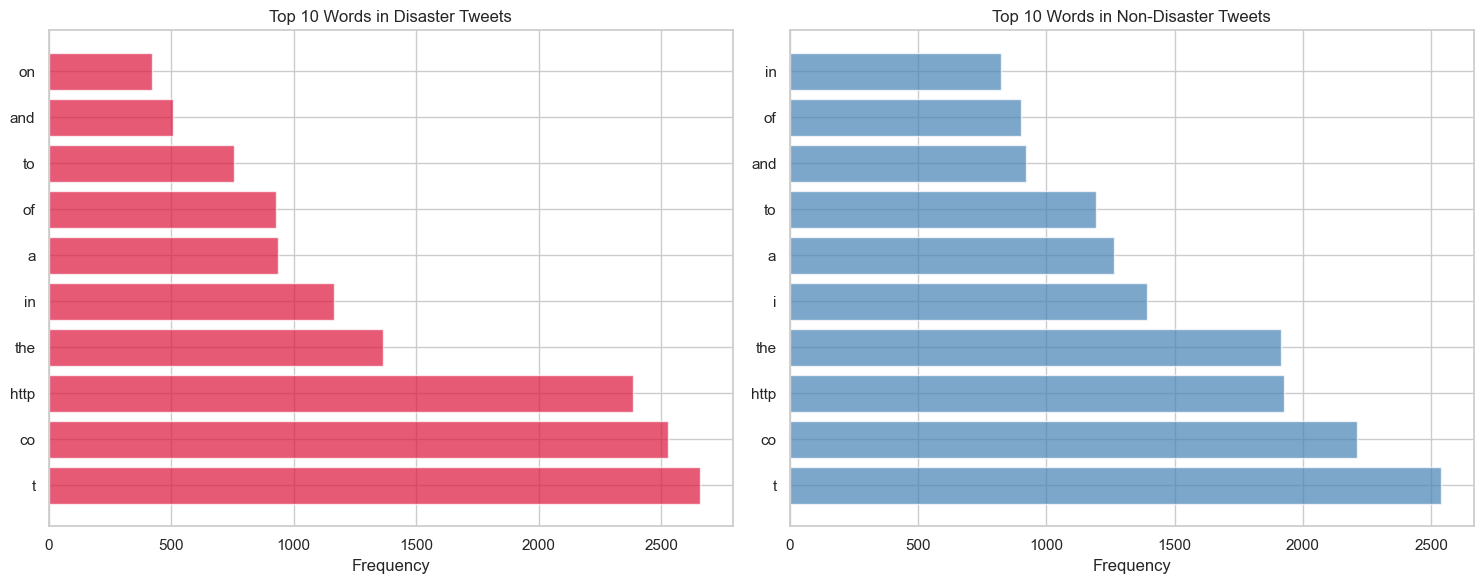

In [29]:
# Frecuencias por clase
disaster_freqs = get_word_counts(disaster_tweets.tolist())
non_disaster_freqs = get_word_counts(non_disaster_tweets.tolist())

# Top 10 palabras por clase
top_disaster = sort_frequencies(disaster_freqs, top_n=10)
top_non_disaster = sort_frequencies(non_disaster_freqs, top_n=10)

# Preparar datos para gráfico
disaster_words, disaster_values = zip(*top_disaster)
non_disaster_words, non_disaster_values = zip(*top_non_disaster)

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.barh(disaster_words, disaster_values, color="crimson", alpha=0.7)
ax1.set_title("Top 10 Words in Disaster Tweets")
ax1.set_xlabel("Frequency")

ax2.barh(non_disaster_words, non_disaster_values, color="steelblue", alpha=0.7)
ax2.set_title("Top 10 Words in Non-Disaster Tweets")
ax2.set_xlabel("Frequency")

plt.tight_layout()
plt.show()


In [30]:
# === Preprocesamiento de texto ===

def preprocess_texts(texts: List[str]) -> List[str]:
    """Limpieza + eliminación de stopwords + filtrado por frecuencia."""
    cleaned = [clean_text(text) for text in texts]

    # Conteo de stopwords
    stopword_counter = Counter()
    for text in cleaned:
        for word in text.split():
            if word in STOPWORDS:
                stopword_counter[word] += 1

    print("Stopwords más frecuentes:")
    for word, count in stopword_counter.most_common(10):
        print(f"{word}: {count}")

    # Eliminar stopwords
    texts_no_stop = [
        " ".join([word for word in text.split() if word not in STOPWORDS])
        for text in cleaned
    ]

    # Filtrar por frecuencia
    freqs = get_word_counts(texts_no_stop)
    min_freq = 2
    max_freq = int(0.1 * len(texts_no_stop))

    valid_words = {
        word for word, freq in freqs.items()
        if min_freq <= freq <= max_freq
    }

    filtered = [
        " ".join([word for word in text.split() if word in valid_words])
        for text in texts_no_stop
    ]
    
    return filtered

# Aplicación del preprocesamiento
texts_filtered = preprocess_texts(df_train["text"].tolist())

# Corrección ortográfica sobre una muestra
def correct_sample_spelling(texts: List[str], n: int = 100) -> List[str]:
    sample = texts[:n]
    corrected = [correct_spelling(text) for text in sample]
    texts[:n] = corrected
    return texts

texts_corrected = correct_sample_spelling(texts_filtered)



Stopwords más frecuentes:
the: 3270
a: 2195
in: 1979
to: 1946
of: 1828
and: 1420
i: 1404
is: 944
for: 893
on: 855


In [31]:
# === Tokenización, Stemming y Lemmatización ===

stemmer = nltk.PorterStemmer()
lemmatizer = nltk.WordNetLemmatizer()

def apply_stemming(texts: List[str]) -> List[str]:
    return [
        " ".join([stemmer.stem(token) for token in tokenize(text)])
        for text in texts
    ]

def apply_lemmatization(texts: List[str]) -> List[str]:
    return [
        " ".join([lemmatizer.lemmatize(token) for token in tokenize(text)])
        for text in texts
    ]

# Aplicar a los textos corregidos
stemmed_texts = apply_stemming(texts_corrected)
lemmatized_texts = apply_lemmatization(texts_corrected)


In [32]:
def compare_vocabulary_stats(original: List[str], stemmed: List[str], lemmatized: List[str]) -> None:
    methods = {
        "Original": original,
        "Stemming": stemmed,
        "Lemmatization": lemmatized
    }

    print(f"{'Método':<15} {'Vocabulario':<15} {'Total palabras':<17} {'Promedio/Tweet'}")
    print("-" * 60)
    
    stats = {}
    for name, texts in methods.items():
        vocab_size, total_words = get_vocabulary_stats(texts)
        avg = total_words / len(texts)
        stats[name] = vocab_size
        print(f"{name:<15} {vocab_size:<15,} {int(total_words):<17,} {avg:.1f}")

    r_stem = (1 - stats["Stemming"] / stats["Original"]) * 100
    r_lemma = (1 - stats["Lemmatization"] / stats["Original"]) * 100

    print("\nReducción del vocabulario:")
    print(f"Stemming     : {r_stem:.1f}%")
    print(f"Lemmatization: {r_lemma:.1f}%")

# Comparación
compare_vocabulary_stats(texts_corrected, stemmed_texts, lemmatized_texts)


Método          Vocabulario     Total palabras    Promedio/Tweet
------------------------------------------------------------
Original        6,212           58,321            7.7
Stemming        4,796           58,283            7.7
Lemmatization   5,529           58,283            7.7

Reducción del vocabulario:
Stemming     : 22.8%
Lemmatization: 11.0%


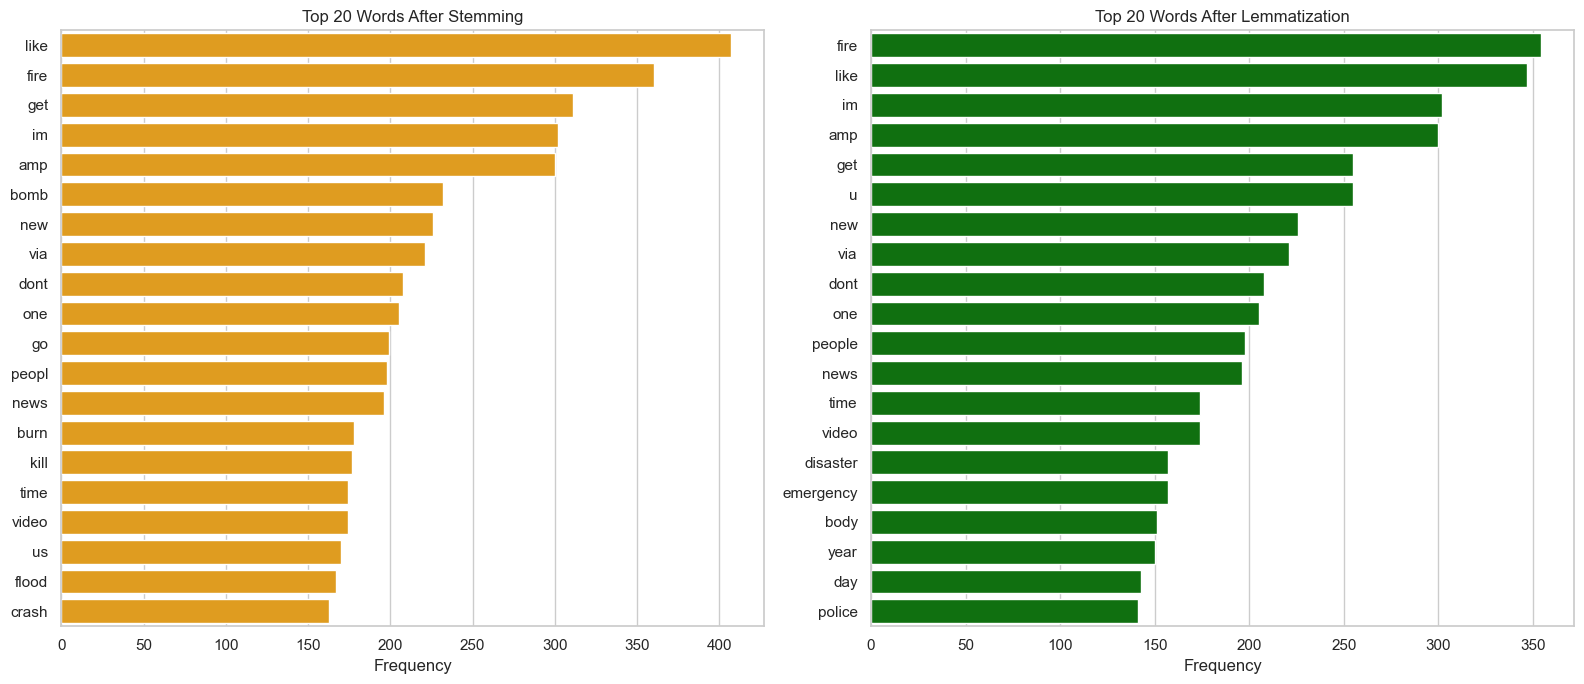

In [33]:
# Frecuencias top 20 por método
freqs_stemmed = get_word_counts(stemmed_texts)
freqs_lemmatized = get_word_counts(lemmatized_texts)

top_stemmed = sort_frequencies(freqs_stemmed, top_n=20)
top_lemmatized = sort_frequencies(freqs_lemmatized, top_n=20)

words_stemmed, counts_stemmed = zip(*top_stemmed)
words_lemmatized, counts_lemmatized = zip(*top_lemmatized)

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

sns.barplot(x=counts_stemmed, y=words_stemmed, ax=ax1, color='orange')
ax1.set_title("Top 20 Words After Stemming")
ax1.set_xlabel("Frequency")

sns.barplot(x=counts_lemmatized, y=words_lemmatized, ax=ax2, color='green')
ax2.set_title("Top 20 Words After Lemmatization")
ax2.set_xlabel("Frequency")

plt.tight_layout()
plt.show()


In [34]:
# Subconjunto de muestra para análisis
sample_texts = lemmatized_texts[:100]

# Vectorizadores
tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    token_pattern=r'\b[a-zA-Z]+\b',
    use_idf=True,
    smooth_idf=True,
    norm='l2'
)

bow_vectorizer = CountVectorizer(
    lowercase=True,
    token_pattern=r'\b[a-zA-Z]+\b'
)

# Aplicar vectorización
tfidf_matrix = tfidf_vectorizer.fit_transform(sample_texts)
bow_matrix = bow_vectorizer.fit_transform(sample_texts)

# Vocabularios
vocab_tfidf = tfidf_vectorizer.get_feature_names_out()
vocab_bow = bow_vectorizer.get_feature_names_out()


In [35]:
def print_vectorizer_metrics(tfidf_matrix, bow_matrix, vocab_tfidf, vocab_bow):
    print("BAG OF WORDS vs TF-IDF COMPARISON")
    print("=" * 55)
    print(f"{'Métrica':<25} {'Bag of Words':<15} {'TF-IDF':<15}")
    print("-" * 55)
    print(f"{'Dimensión matriz':<25} {str(bow_matrix.shape):<15} {str(tfidf_matrix.shape):<15}")
    print(f"{'Tamaño vocabulario':<25} {len(vocab_bow):<15} {len(vocab_tfidf):<15}")
    print(f"{'Tipo de dato':<25} {'Conteos':<15} {'Pesos':<15}")
    print(f"{'Sparsity (%)':<25} {(1 - bow_matrix.nnz / bow_matrix.size) * 100:<15.1f} {(1 - tfidf_matrix.nnz / tfidf_matrix.size) * 100:<15.1f}")

print_vectorizer_metrics(tfidf_matrix, bow_matrix, vocab_tfidf, vocab_bow)


BAG OF WORDS vs TF-IDF COMPARISON
Métrica                   Bag of Words    TF-IDF         
-------------------------------------------------------
Dimensión matriz          (100, 355)      (100, 355)     
Tamaño vocabulario        355             355            
Tipo de dato              Conteos         Pesos          
Sparsity (%)              0.0             0.0            


In [36]:
sample_idx = 0
sample_text = sample_texts[sample_idx]
bow_vector = bow_matrix[sample_idx].toarray().flatten()
tfidf_vector = tfidf_matrix[sample_idx].toarray().flatten()

print(f"\nANÁLISIS DOCUMENTO EJEMPLO ({sample_idx})")
print(f"Texto: {sample_text}\n")
print(f"{'Palabra':<15} {'BoW Count':<12} {'TF-IDF Score':<12} {'Diferencia'}")
print("-" * 55)

for word in sample_text.split():
    if word in vocab_bow and word in vocab_tfidf:
        idx_bow = np.where(vocab_bow == word)[0][0]
        idx_tfidf = np.where(vocab_tfidf == word)[0][0]
        bow_count = bow_vector[idx_bow]
        tfidf_score = tfidf_vector[idx_tfidf]
        diff = abs(bow_count - tfidf_score)
        print(f"{word:<15} {bow_count:<12} {tfidf_score:<12.4f} {diff:.4f}")



ANÁLISIS DOCUMENTO EJEMPLO (0)
Texto: deed reason earthquake may allah forgive u

Palabra         BoW Count    TF-IDF Score Diferencia
-------------------------------------------------------
deed            1            0.3874       0.6126
reason          1            0.3874       0.6126
earthquake      1            0.3874       0.6126
may             1            0.3874       0.6126
allah           1            0.3874       0.6126
forgive         1            0.3874       0.6126
u               1            0.3153       0.6847


In [37]:
def find_most_similar_tweet(query: str, vectorizer, matrix, original_texts: List[str]) -> Tuple[int, str, float]:
    """
    Devuelve el índice, texto y score del tweet más similar a la consulta.
    """
    # Preprocesar la consulta como el resto de los textos
    query_clean = clean_text(query)
    query_lemmatized = " ".join([LEMMATIZER.lemmatize(w) for w in tokenize(query_clean)])
    
    # Vectorizar la consulta
    query_vector = vectorizer.transform([query_lemmatized])
    
    # Calcular similitud coseno
    similarities = cosine_similarity(query_vector, matrix).flatten()
    
    # Obtener índice del más similar
    most_similar_idx = similarities.argmax()
    similarity_score = similarities[most_similar_idx]
    
    return most_similar_idx, original_texts[most_similar_idx], similarity_score


In [38]:
# Usaremos los primeros 100 textos lematizados como corpus
corpus = sample_texts  # mismos de tfidf_matrix

# Simular una consulta
query = "Fire in the city center"

# Buscar tweet más similar
idx, tweet, score = find_most_similar_tweet(query, tfidf_vectorizer, tfidf_matrix, corpus)

print("CONSULTA:")
print(query)
print("\nTWEET MÁS SIMILAR:")
print(tweet)
print(f"\nScore de similitud coseno: {score:.4f}")


CONSULTA:
Fire in the city center

TWEET MÁS SIMILAR:
rockyfire update california closed due lake county fire fire wildfire

Score de similitud coseno: 0.2452


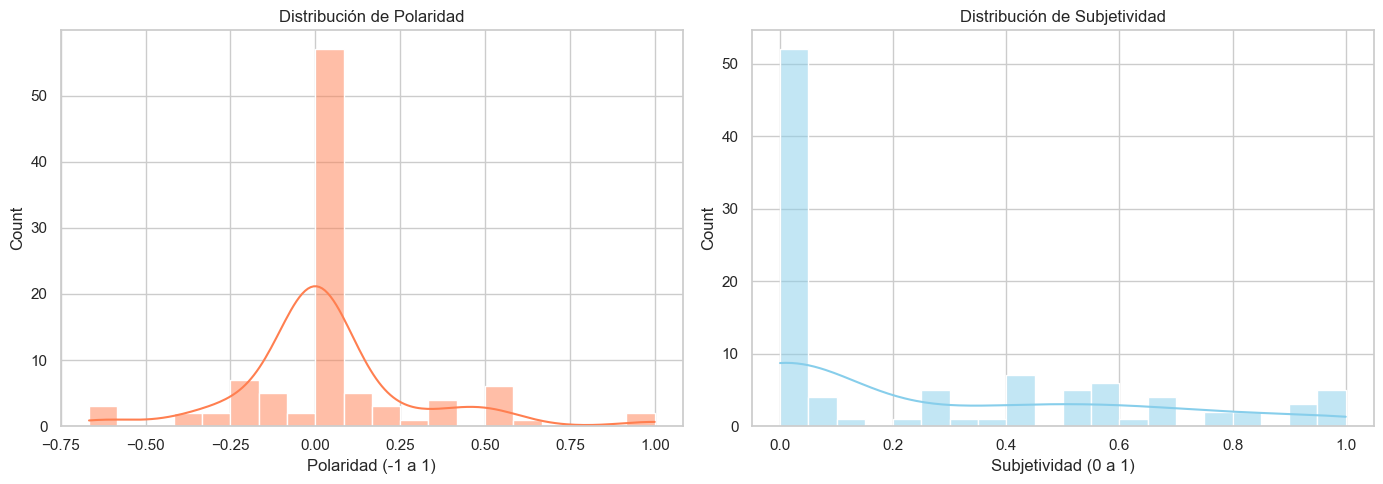

In [39]:
def analyze_sentiment(text: str) -> Tuple[float, float]:
    """
    Retorna polaridad y subjetividad de un texto.
    """
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity


def apply_sentiment_analysis(texts: List[str], sample_size: int = 100) -> pd.DataFrame:
    """
    Retorna DataFrame con texto, polaridad y subjetividad.
    """
    sample_texts = texts[:sample_size]
    results = []

    for text in sample_texts:
        polarity, subjectivity = analyze_sentiment(text)
        results.append({
            "text": text,
            "polarity": polarity,
            "subjectivity": subjectivity
        })

    return pd.DataFrame(results)

sentiment_df = apply_sentiment_analysis(lemmatized_texts)

def plot_sentiment_distributions(df: pd.DataFrame):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.histplot(df["polarity"], bins=20, kde=True, ax=axes[0], color='coral')
    axes[0].set_title("Distribución de Polaridad")
    axes[0].set_xlabel("Polaridad (-1 a 1)")

    sns.histplot(df["subjectivity"], bins=20, kde=True, ax=axes[1], color='skyblue')
    axes[1].set_title("Distribución de Subjetividad")
    axes[1].set_xlabel("Subjetividad (0 a 1)")

    plt.tight_layout()
    plt.show()

plot_sentiment_distributions(sentiment_df)


In [40]:
print(f"Promedio de polaridad    : {sentiment_df['polarity'].mean():.2f}")
print(f"Promedio de subjetividad : {sentiment_df['subjectivity'].mean():.2f}")

Promedio de polaridad    : 0.03
Promedio de subjetividad : 0.26


## Conclusiones

En este análisis se aplicaron técnicas fundamentales de procesamiento y exploración de texto. Se limpiaron y transformaron los datos, aplicando desde la eliminación de ruido hasta métodos de normalización léxica (stemming y lematización). 
Se compararon representaciones vectoriales con CountVectorizer y TfidfVectorizer, analizando sus diferencias estructurales y de densidad. 
También se utilizó distancia coseno para encontrar el tweet más similar a una consulta dada, mostrando una aplicación práctica del modelo vectorial.
Finalmente, el análisis de sentimiento mediante TextBlob permitió identificar tendencias generales de polaridad y subjetividad dentro del corpus. Esto entrega una base interpretativa para entender el tono emocional de los mensajes en contextos de emergencia o eventos reales.
Este flujo representa una estructura básica, pero sólida, para abordar problemas de clasificación de texto o minería de opiniones en contextos reales.
